In [178]:
import pandas as pd
import numpy as np
import glob
import os
import datetime

startDate = '20200914'
endDate = '20200930'



readPath = r'\\192.168.10.30\Kevin_zhenyu\orderLog\equityTradeLogs'
dataPathLs = np.array(glob.glob(os.path.join(readPath, 'speedCompare***.csv')))
dateLs = np.array([os.path.basename(i).split('_')[1].split('.')[0] for i in dataPathLs])
dataPathLs = dataPathLs[(dateLs >= startDate) & (dateLs <= endDate)]
rawOrderLog = []
for thisDate, thisPath in zip(dateLs, dataPathLs):
    data = pd.read_csv(thisPath)
    data = data.rename(columns={'mdClockAtArrival': 'caamd'})
    rawOrderLog += [data]
rawOrderLog = pd.concat(rawOrderLog, sort=False)

# rawOrderLog = pd.read_pickle(r'A:\temp\speedCheck\zt96_statwo_20200818.pkl')


for col in ['clockAtArrival', 'caamd', 'secid', 'updateType', 'vai', 'absFilledThisUpdate', 'orderDirection', 'absOrderSize',
            'absOrderSizeCumFilled', 'date', 'accCode', 'mse']:
    rawOrderLog[col] = rawOrderLog[col].astype('int64')   
rawOrderLog = rawOrderLog.sort_values(by=['date', 'secid', 'vai', 'accCode', 'clockAtArrival']).reset_index(drop=True)

rawOrderLog = rawOrderLog[rawOrderLog["secid"] >= 1000000]

rawOrderLog['clock'] = rawOrderLog['clockAtArrival'].apply(lambda x: datetime.datetime.fromtimestamp(x/1e6))
rawOrderLog['broker'] = rawOrderLog['accCode'] // 100
rawOrderLog["broker"] = np.where(rawOrderLog["accCode"].astype(str).apply(lambda x: len(x) == 6), rawOrderLog['accCode'] // 10000, rawOrderLog["broker"])
rawOrderLog['colo_broker'] = rawOrderLog['colo'].str[:2] + '_' + rawOrderLog['broker'].astype('str')
rawOrderLog['order'] = rawOrderLog.groupby(['date', 'accCode', 'secid', 'vai']).grouper.group_info[0]
rawOrderLog['group'] = rawOrderLog.groupby(['date', 'secid', 'vai']).grouper.group_info[0]
rawOrderLog['startClock'] = rawOrderLog.groupby(['order'])['clockAtArrival'].transform('first')
rawOrderLog['duration'] = rawOrderLog['clockAtArrival'] - rawOrderLog['startClock']
rawOrderLog['orderPrice'] = rawOrderLog['orderPrice'].apply(lambda x: round(x, 2))
rawOrderLog['tradePrice'] = rawOrderLog['tradePrice'].apply(lambda x: round(x, 2))
rawOrderLog['orderDirection1'] = np.where(rawOrderLog["orderDirection"] == -2, -1, np.where(
    rawOrderLog["orderDirection"] == 2, 1, rawOrderLog["orderDirection"]))
orderLog = rawOrderLog.copy()

### Assertion 1:  make sure same direction in same date, secid, vai
print('=======================================================================================')
print('1. same date, secid, vai: same direction')
orderLog['directNum'] = orderLog.groupby(['date', 'secid', 'vai'])['orderDirection1'].transform('nunique')
if len(orderLog[orderLog['directNum'] != 1]) > 0:
    print('opposite direction for same date, same secid, same vai')
    display(orderLog[(orderLog['directNum'] != 1) & (orderLog['updateType'] == 0)][['date', 'accCode', 'secid', 'vai', 'orderDirection', 'order']])
    orderLog = orderLog[orderLog['directNum'] == 1]

assert((orderLog.groupby(['date', 'secid', 'vai'])['orderDirection1'].nunique() == 1).all() == True)

## Assertion 2:  make sure each account, secid, vai only has one insertion
print('=======================================================================================')
print('2. same date, secid, vai, accCode: one insertion')
a = orderLog[orderLog['updateType'] == 0].groupby(['date', 'accCode', 'secid', 'vai', 'order'])['clockAtArrival'].count()
if len(a[a > 1]) > 0:
    print('more than one insertion at same time')
    a = a[a>1].reset_index()
    display(a)
    orderLog = orderLog[~(orderLog['order'].isin(a['order'].unique()))]

orderLog['isMsg'] = np.where(orderLog['updateType'] == 0, 
                             np.where(orderLog['mse'] == 100, 1, 0), np.nan)
orderLog['isMsg'] = orderLog.groupby(['order'])['isMsg'].ffill()

placeSZE = orderLog[(orderLog['secid'] >= 2000000) & (orderLog['updateType'] == 0)]
print('%.2f%% SZE orders triggered by msg data'%(placeSZE[placeSZE['isMsg'] == 1].shape[0]/placeSZE.shape[0]*100))


### Assertion 3:  check IPO stocks selling status
print('=======================================================================================')
print('3. IPO stocks selling (ars = 301, 302)')
if orderLog[orderLog['ars'].isin([301, 302])].shape[0] != 0:
    kk = orderLog[orderLog['ars'].isin([301, 302])]
    print(kk)
    try:
        assert(kk[kk['orderDirection1'] == 1].shape[0] == 0)
        print('we only sell, never buy')
    except:
        print('There are IPO buy side orders!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
        print(kk[kk['orderDirection1'] == 1])
    kk1 = kk[kk['updateType'] == 0]
    kk1 = kk1.sort_values(by=['accCode', 'secid','clockAtArrival'])
    kk1['diff'] = kk1.groupby(['accCode', 'secid'])['clockAtArrival'].apply(lambda x: x-x.shift(1))
    kk1['diff'] = kk1['diff'].fillna(0)
    try:
        assert(kk1[kk1['diff'] < 10e6].shape[0] == 0)
        print('for each stock in the same account, there is no insertion within 10 seconds of the previous insertion')
    except:
        print('There are insertion within 10 seconds for orders under same account same stock!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
        print(kk1[kk1['diff'] < 10e6])
    kk2 = kk[(kk['updateType'] == 1)]
    try:
        assert(kk2[kk2['duration'] < 3e6].shape[0] == 0)
        print('for each stock in the same account, the cancellation of an order happens more than 3 seconds after the insertion')
    except:
        print('There are cancellation within 3 seconds for orders under same account same stock!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
        print(kk2[kk2['duration'] < 3e6])


### Assertion 4: check updateType == 7 orders, make sure updateType == 7 orders < 20 per account, < 100 in total
print('=======================================================================================')
print('4. updateType 7 orders')
if orderLog[orderLog['updateType'] == 7].shape[0] != 0:
    assert(orderLog[orderLog['updateType'] == 7].groupby('accCode')['order'].nunique().max() < 20)
    assert(orderLog[orderLog['updateType'] == 7].groupby('accCode')['order'].nunique().sum() < 100)

### Assertion 5: check updateType == 6 orders, make sure updateType == 6 orders < 5% per account
print('=======================================================================================')
print('5. updateType 6 orders')
k1 = orderLog[orderLog['updateType'] == 6].groupby('accCode')['order'].nunique().reset_index()
k2 = orderLog.groupby('accCode')['order'].nunique().reset_index()
k = pd.merge(k1, k2, on='accCode', how='left')
k['prob'] = k['order_x']/k['order_y']
try:
    assert(sum(k['prob'] >= 0.05) == 0)
except:
    print('There are accounts with more than 5% updateType 6 orders!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
    print(k[k['prob'] >= 0.05])

### Assertion 6: check CYB orders, make sure CYB stocks total absOrderSize < 30w
print('=======================================================================================')
print('6. CYB stocks total order size < 30w')
try:
    assert(orderLog[(orderLog['secid'] >= 2300000) & (orderLog['updateType'] == 0)]['absOrderSize'].max() <= 300000)
except:
    print('CYB stocks total absOrderSize >= 30w!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
    
     
### Assertion 7:  make sure there is no unexpected updateType 
print('=======================================================================================')
print('7. unexpected updateType')
def getTuple(x):
    return tuple(i for i in x)

checkLog = orderLog[~((orderLog['updateType'] == 4) & (orderLog.groupby(['order'])['updateType'].shift(-1) == 4))]
checkLog = checkLog.groupby(['order'])['updateType'].apply(lambda x: getTuple(x)).reset_index()
checkLog['status'] = np.where(checkLog['updateType'].isin([(0, 2, 4), (0, 2, 1, 4), (0, 2, 1, 2, 4), (0, 2, 4, 1, 4), (0, 4), (0, 1, 4), (0, 4, 1, 4), (0, 2, 2, 4), (0, 4, 2, 4), (0, 2, 2, 1, 4), (0, 2, 2, 4, 1, 4)]),0,
                     np.where(checkLog['updateType'].isin([(0, 2, 4, 1, 3), (0, 2, 4, 1, 4, 3), (0, 2, 1, 4, 3), (0, 4, 1, 3), (0, 1, 4, 3),
                                                               (0, 2, 2, 4, 1, 3), (0, 2, 2, 4, 1, 4, 3), (0, 2, 2, 1, 4, 3), (0, 4, 2, 4, 1, 3),
                                                               (0, 4, 2, 1, 3), (0, 4, 1, 4, 3), (0, 4, 1)]), 1,
                     np.where(checkLog['updateType'].isin([(0, 2, 1, 3), (0, 2, 2, 1, 3), (0, 2, 3), (0, 3), (0, 1, 3), (0, ), (0, 2), (0, 2, 1), (0, 2, 2)]), 2, 3)))

orderLog = pd.merge(orderLog, checkLog[['order', 'status']], how='left', on=['order'], validate='many_to_one')
orderLog = orderLog[orderLog['status'].isin([0, 1, 2])].reset_index(drop=True)

### Assertion 8:  make sure status==0 got all traded
print('=======================================================================================')
print('8. status == 0: all traded')
a = orderLog[orderLog['status'] == 0]
a = a.groupby(['order'])[['absOrderSizeCumFilled', 'absOrderSize']].max().reset_index()
a.columns = ['order', 'filled', 'total']
print('in total trade, any fill != total cases')
display(a[a['filled'] != a['total']])
if a[a['filled'] != a['total']].shape[0] > 0:
    removeOrderLs = a[a['filled'] != a['total']]['order'].unique()
    orderLog = orderLog[~(orderLog['order'].isin(removeOrderLs))]
    
### Assertion 9:  make sure status==1 got partial traded
print('=======================================================================================')
print('9. status == 1: partial traded')
a = orderLog[orderLog['status'] == 1]
a = a.groupby(['order'])[['absOrderSizeCumFilled', 'absOrderSize']].max().reset_index()
a.columns = ['order', 'filled', 'total']
print('in partial trade, any fill >= total or fill is 0 cases for updateType 4')
display(a[(a['filled'] >= a['total']) | (a['filled'] == 0)])
if a[(a['filled'] >= a['total']) | (a['filled'] == 0)].shape[0] > 0:
    removeOrderLs = a[(a['filled'] >= a['total']) | (a['filled'] == 0)]['order'].unique()
    orderLog = orderLog[~(orderLog['order'].isin(removeOrderLs))]
    
### Assertion 10: make sure no cancellation within 1 sec
print('=======================================================================================')
print('10. no cancellation within 1 sec')
a = orderLog[(orderLog['updateType'] == 1) & (orderLog['duration'] < 1e6)]
print('any cancellation within 1 sec')
display(a)
if a.shape[0] > 0:
    removeOrderLs = a['order'].unique()
    orderLog = orderLog[~(orderLog['order'].isin(removeOrderLs))]


### Assertion 11: make sure no order has shares > 80w or notional > 800w
print('=======================================================================================')
print('11. Orders with size > 80w or notional > 800w')
orderLog['orderNtl'] = orderLog['absOrderSize'] * orderLog['orderPrice']
if orderLog[orderLog['absOrderSize'] > 800000].shape[0] > 0:
    print('some order quantity are > 80w')
    print(orderLog[orderLog['absOrderSize'] > 800000].groupby(['colo', 'accCode'])['order'].nunique())
    display(orderLog[orderLog['absOrderSize'] > 800000][['date', 'accCode', 'secid', 'vai', 'absOrderSize', 'orderPrice',
                                                         'orderNtl', 'orderDirection', 'clock', 'order']])
            
if orderLog[orderLog['orderNtl'] > 8000000].shape[0] > 0:
    print('some order ntl are > 800w')
    print(orderLog[orderLog['orderNtl'] > 8000000].groupby(['colo', 'accCode'])['order'].nunique())
    display(orderLog[orderLog['orderNtl'] > 8000000][['date', 'accCode', 'secid', 'vai', 'absOrderSize', 'orderPrice',
                                                      'orderNtl', 'orderDirection', 'clock', 'order', "updateType", 
                                                      "tradePrice", "absOrderSizeCumFilled", "absFilledThisUpdate"]])

removeOrderLs = list(set(orderLog[orderLog['absOrderSize'] > 800000]['order'].unique()) | set(orderLog[orderLog['orderNtl'] > 8000000]['order'].unique()))
orderLog = orderLog[~(orderLog['order'].isin(removeOrderLs))]

orderLog = orderLog.sort_values(by=['date', 'secid', 'vai', 'accCode', 'clockAtArrival']).reset_index(drop=True)

orderLog['exchange'] = np.where(orderLog['secid'] >= 2000000, 'SZE', 'SSE')
orderLog['orderNtl'] = orderLog['orderPrice'] * orderLog['absOrderSize']
orderLog['tradeNtl'] = np.where(orderLog['updateType'] == 4, orderLog['tradePrice']*orderLog['absFilledThisUpdate'], 0)
orderLog['tradeNtl'] = orderLog.groupby('order')['tradeNtl'].transform('sum')
orderLog["ars"] = orderLog.groupby(['order'])['ars'].transform('first')
orderLog['sta'] = np.where(orderLog['ars'].isin([121, 221, 321, 131, 231, 331]), 'statwo', 'staone')
orderLog['cumFillSize'] = orderLog.groupby(['order'])['absOrderSizeCumFilled'].transform('max')
orderLog['status'] = np.where(orderLog['cumFillSize'] == 0, '3. no filled', 
                                np.where(orderLog['cumFillSize'] < orderLog['absOrderSize'], '2. partial filled', '1. full filled'))


startDate = '20200914'
endDate = '20200930'
readPath = r'L:\orderLog\result\marketPos'
dataPathLs = np.array(glob.glob(os.path.join(readPath, 'SZspeed_***.pkl')))
dateLs = np.array([os.path.basename(i).split('.')[0].split('_')[1] for i in dataPathLs])
dataPathLs = dataPathLs[(dateLs >= startDate) & (dateLs <= endDate)]
checkData = []
for path in dataPathLs:
    data = pd.read_pickle(path)
    checkData += [data]
checkLog = pd.concat(checkData).reset_index(drop=True)   
display(checkLog['date'].unique())

checkLog = checkLog.drop_duplicates(['date', 'secid', 'Price', 'OrderQty', 'Side', 'statusLs', 'TradePriceLs', 'TradeQtyLs', 'ApplSeqNum'], keep=False)
checkLog = checkLog[~checkLog['accCode'].isnull()]
# checkLog = pd.merge(checkLog, orderLog[(orderLog['updateType'] == 0) & (orderLog['exchange'] == 'SZE')
#                                 & (orderLog['ApplSeqNum'] != 0)][['orderDirection', 'date', 'colo', 'accCode', 'secid', 'ApplSeqNum', 'status', 'orderNtl', 'tradeNtl', 'colo_broker']],
#              on=['date', 'colo', 'accCode', 'secid', 'ApplSeqNum'])
# checkLog['time_diff'] = checkLog['clockAtArrival'] - checkLog['start_time']

C:\Users\win\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\win\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (17,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\win\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (17,26) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\win\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (17,19,25) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


1. same date, secid, vai: same direction
opposite direction for same date, same secid, same vai


,date,accCode,secid,vai,orderDirection,order
56323,20200914,8854,1603008,8905434,-1,30680
56326,20200914,528701,1603008,8905434,1,62141
70068,20200914,8854,1603298,2761528,-1,30710
70071,20200914,9551,1603298,2761528,1,41692
194557,20200914,5456,2002880,774305,1,19871
...,...,...,...,...,...,...
3591314,20200930,6623,2002677,1616000,-1,872855
3591318,20200930,6627,2002677,1616000,-1,873943
3591322,20200930,8854,2002677,1616000,1,876543
3591325,20200930,8865,2002677,1616000,-1,877120


2. same date, secid, vai, accCode: one insertion
more than one insertion at same time


,date,accCode,secid,vai,order,clockAtArrival
0,20200914,5273,2300550,3100,7203,2
1,20200914,6683,2000688,1852523,27948,2
2,20200914,6683,2300723,1201900,29521,2
3,20200914,8854,2000688,2980019,30834,2
4,20200914,8854,2002961,556897,31125,2
...,...,...,...,...,...,...
526,20200930,9741,2002735,1029020,890098,2
527,20200930,9741,2002802,340600,890201,2
528,20200930,9741,2300492,151700,891001,2
529,20200930,9741,2300522,1074820,891087,2


99.64% SZE orders triggered by msg data
3. IPO stocks selling (ars = 301, 302)
4. updateType 7 orders
5. updateType 6 orders
6. CYB stocks total order size < 30w
7. unexpected updateType
8. status == 0: all traded
in total trade, any fill != total cases


,order,filled,total
7429,9735,300,400
8203,10691,6200,14600
9187,11799,90000,143700
10058,12769,2200,2300
15319,18984,3400,32200
...,...,...,...
646194,903421,500,800
646294,903542,19050,49000
646629,903970,19500,23300
648388,906732,500,700


9. status == 1: partial traded
in partial trade, any fill >= total or fill is 0 cases for updateType 4


,order,filled,total


10. no cancellation within 1 sec
any cancellation within 1 sec


,Unnamed: 0,clockAtArrival,caamd,secid,updateType,vai,ars,absFilledThisUpdate,orderDirection,absOrderSize,absOrderSizeCumFilled,orderPrice,tradePrice,date,accCode,mse,colo,orderSysId,internalId,tradeId,sdd,aaa,ApplSeqNum,mrm,mta,mrsb,mrss,mrv,mrb100,mra100,l4tr,clock,broker,colo_broker,order,group,startClock,duration,orderDirection1,directNum,isMsg,status


11. Orders with size > 80w or notional > 800w


array([20200914, 20200915, 20200916, 20200917, 20200918, 20200921,
       20200922, 20200923, 20200924, 20200925, 20200928, 20200929,
       20200930], dtype=int64)

In [185]:
checkLog1 = checkLog[checkLog['orderDirection'].isin([1, -1])]
checkLog2 = checkLog[checkLog['orderDirection'].isin([-2, 2])]
checkLog1['use'] = np.where((checkLog1['colo'].str[:2] == 'zs') & (checkLog1['time_diff'] <= 20000), 1, np.where(
(checkLog1['colo'].str[:2] == 'zt') & (checkLog1['time_diff'] <= 100000), 1, np.where(checkLog1['accCode'].isin([6282, 6237]), 1, 0)))
checkLog1 = checkLog1[checkLog1['use'] == 1]

In [198]:
checkLog1[checkLog1['colo'].str[:2] == 'zs'].groupby('broker')['time_diff'].max()

broker
zs_52    19810.0
zs_54    15365.0
zs_64    14437.0
zs_66    14075.0
zs_88    19629.0
zs_92     8138.0
zs_94    99940.0
zs_96    99953.0
Name: time_diff, dtype: float64

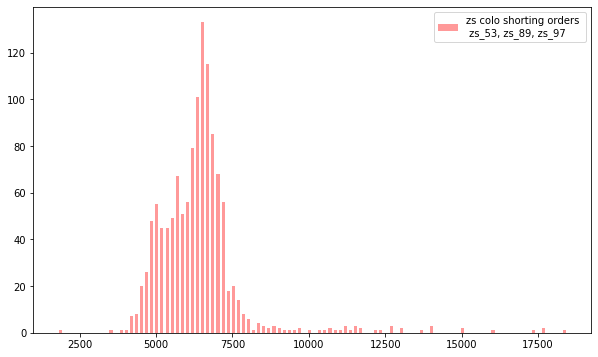

In [171]:
checkLog2 = checkLog[checkLog['orderDirection'].isin([-2, 2])]
fig = plt.figure(figsize=(10, 6))
ax1 = fig.add_subplot(111)
ax1.hist(checkLog2[(checkLog2['colo'].str[:2] == 'zs') & (checkLog2['time_diff'] <= 20000) & (checkLog2['colo_broker'] == 'zs_89')]['time_diff'].values, bins=100, rwidth=0.6, alpha=0.4, color='red', label='zs colo shorting orders \n zs_53, zs_89, zs_97')
ax1.legend()
plt.show()

In [167]:
checkLog2[(checkLog2['colo'].str[:2] == 'zs') & (checkLog2['time_diff'] <= 20000)].groupby(['colo_broker', 'sta'])['OrderQty'].size()

colo_broker  sta   
zs_53        staone      13
             statwo     280
zs_89        staone     140
             statwo    1098
zs_97        staone     472
             statwo    3275
Name: OrderQty, dtype: int64

In [207]:
checkLog2.groupby('broker')['accCode'].unique()

broker
zs_52            [5386.0]
zs_88            [8967.0]
zs_96            [9754.0]
zt_52          [537403.0]
zt_88    [8971.0, 8970.0]
Name: accCode, dtype: object

In [24]:
checkLog['use'] = np.where((checkLog['colo'].str[:2] == 'zs') & (checkLog['time_diff'] <= 20000), 1, np.where(
(checkLog['colo'].str[:2] == 'zt') & (checkLog['time_diff'] <= 100000), 1, np.where(checkLog['accCode'].isin([6282, 6237]), 1, 0)))
checkLog['broker'] = checkLog['colo'].str[:2] + '_' + checkLog['accCode'].astype(str).str[:2]
checkLog1 = checkLog[checkLog['use'] == 1]

In [138]:
bins = [2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200, 3300, 3400, 3500, 3600, 3700, 3800, 3900, 4000]
data=checkLog1[(checkLog1['broker'].isin(['zs_52', 'zs_54', 'zs_66', 'zs_92', 'zs_94', 'zs_96', 'zs_97']))]['time_diff'].values
cats = pd.cut(data,bins)
pd.value_counts(cats).reset_index().sort_values(by='index')

,index,0
19,"(2000, 2100]",29
18,"(2100, 2200]",57
17,"(2200, 2300]",289
16,"(2300, 2400]",1446
15,"(2400, 2500]",4977
9,"(2500, 2600]",11921
6,"(2600, 2700]",19154
5,"(2700, 2800]",20021
8,"(2800, 2900]",15265
10,"(2900, 3000]",10799


In [217]:
checkLog1[(checkLog1['broker'].isin(['zs_52', 'zs_54', 'zs_66', 'zs_92', 'zs_94', 'zs_96'])) & (checkLog1['time_diff'] >= 3600) & (checkLog1['time_diff'] <= 3900) & (~checkLog1['accCode'].isin([6237, 6282]))].groupby(['Side'])['SecurityID'].size()

Side
1.0     10594
2.0    104935
Name: SecurityID, dtype: int64

In [218]:
checkLog1[(checkLog1['broker'].isin(['zs_52', 'zs_54', 'zs_66', 'zs_92', 'zs_94', 'zs_96', 'zs_97'])) & (checkLog1['time_diff'] >= 2600) & (checkLog1['time_diff'] <= 2900) & (~checkLog1['accCode'].isin([6237, 6282]))].groupby(['Side'])['SecurityID'].size()

Side
1.0    54438
2.0       78
Name: SecurityID, dtype: int64

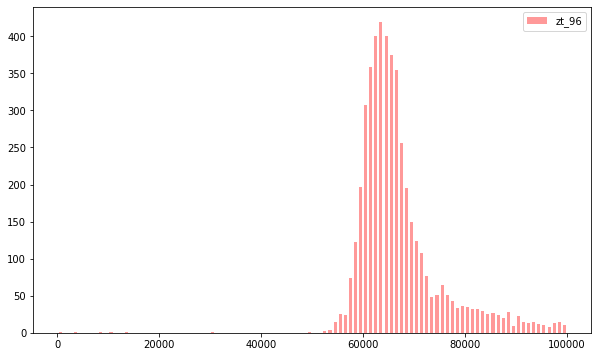

In [176]:
fig = plt.figure(figsize=(10, 6))
ax1 = fig.add_subplot(111)
ax1.hist(checkLog1[(checkLog1['broker'] == 'zs_62') & (checkLog1['accCode'] == 6282)]['time_diff'].values, bins=100, rwidth=0.6, alpha=0.4, color='red', label=i)
ax1.legend()
plt.show()

In [136]:
checkLog1[(checkLog1['broker'] == 'zs_54') & (checkLog1['accCode'] == 5456) & (checkLog1['time_diff'] >= 2600) & (checkLog1['time_diff'] <= 2900)].groupby('ars')['Side'].size()

ars
11.0    346
Name: Side, dtype: int64

In [137]:
checkLog1[(checkLog1['broker'] == 'zs_54') & (checkLog1['accCode'] == 5470) & (checkLog1['time_diff'] >= 3500) & (checkLog1['time_diff'] <= 3800)].groupby('ars')['Side'].size()

ars
11.0    2049
Name: Side, dtype: int64

In [124]:
449 / (87 + 449)

0.8376865671641791

In [115]:
bins = [2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200, 3300, 3400, 3500, 3600, 3700, 3800, 3900, 4000]
data=checkLog1[(checkLog1['broker'] == 'zs_54') & (checkLog1['accCode'] == 5470)]['time_diff'].values
cats = pd.cut(data,bins)
pd.value_counts(cats).reset_index().sort_values(by='index')

,index,0
19,"(2000, 2100]",0
18,"(2100, 2200]",0
17,"(2200, 2300]",1
16,"(2300, 2400]",13
15,"(2400, 2500]",46
12,"(2500, 2600]",206
4,"(2600, 2700]",459
3,"(2700, 2800]",591
7,"(2800, 2900]",402
10,"(2900, 3000]",237


In [234]:
np.sort(checkLog2['broker'].unique())

array(['zs_52', 'zs_88', 'zs_96', 'zt_52', 'zt_88'], dtype=object)

In [242]:
checkLog[checkLog['broker'] == 'zt_52']['orderDirection'].unique()

array([-2,  2], dtype=int64)

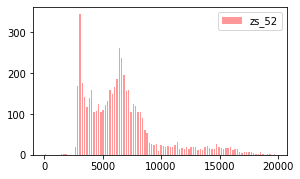

In [224]:
fig = plt.figure(figsize=(10, 6))
ax1 = fig.add_subplot(221)
ax1.hist(checkLog2[(checkLog2['broker'].isin(np.sort(checkLog2['broker'].unique())[:3])) & (checkLog2['time_diff'] <= 20000)]['time_diff'].values, bins=100, rwidth=0.6, alpha=0.4, color='red', label=np.sort(checkLog2['broker'].unique())[0])
ax1.legend()

In [245]:
checkLog[checkLog['accCode'].isin([6237, 6282])]['orderDirection'].unique()

array([ 1, -1], dtype=int64)

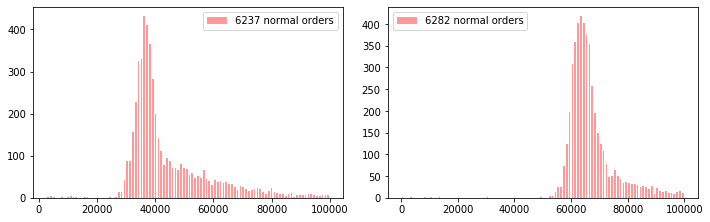

In [246]:
fig = plt.figure(figsize=(10, 6))
ax1 = fig.add_subplot(221)
ax1.hist(checkLog1[(checkLog1['accCode'] == 6237)]['time_diff'].values, bins=100, rwidth=0.6, alpha=0.4, color='red', label='6237 normal orders')
ax1.legend()

ax1 = fig.add_subplot(222)
ax1.hist(checkLog1[(checkLog1['accCode'] == 6282)]['time_diff'].values, bins=100, rwidth=0.6, alpha=0.4, color='red', label='6282 normal orders')
ax1.legend()


fig.tight_layout()
plt.show()

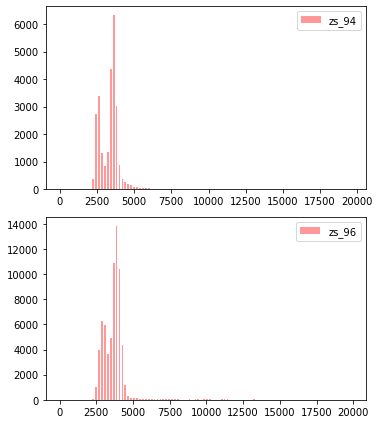

In [216]:
fig = plt.figure(figsize=(10, 6))
ax1 = fig.add_subplot(221)
ax1.hist(checkLog1[(checkLog1['broker'] == np.sort(checkLog1['broker'].unique())[6]) & (checkLog1['accCode'] != 6237)]['time_diff'].values, bins=100, rwidth=0.6, alpha=0.4, color='red', label=np.sort(checkLog1['broker'].unique())[6])
ax1.legend()

ax2 = fig.add_subplot(223)
ax2.hist(checkLog1[(checkLog1['broker'] == np.sort(checkLog1['broker'].unique())[7]) & (checkLog1['accCode'] != 6282)]['time_diff'].values, bins=100, rwidth=0.6, alpha=0.4, color='red', label=np.sort(checkLog1['broker'].unique())[7])
ax2.legend()

fig.tight_layout()
plt.show()

In [193]:
checkLog2.groupby('broker')['accCode'].unique()

broker
zs_52            [5386.0]
zs_88            [8967.0]
zs_96            [9754.0]
zt_52          [537403.0]
zt_88    [8971.0, 8970.0]
Name: accCode, dtype: object

C:\Users\win\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


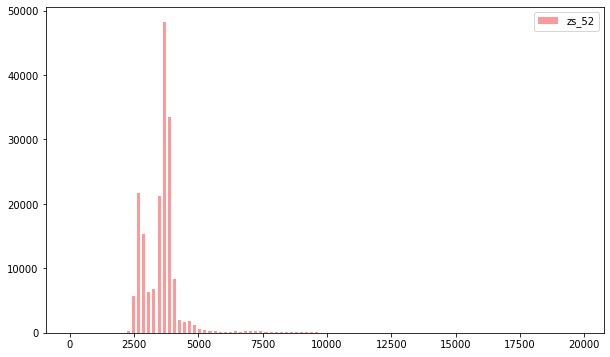

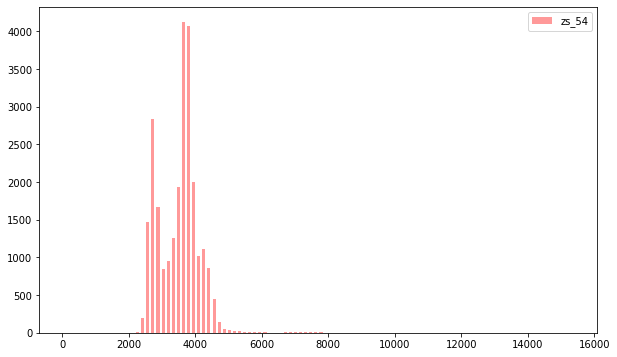

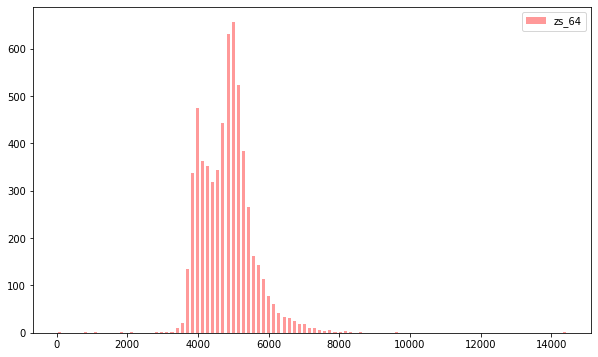

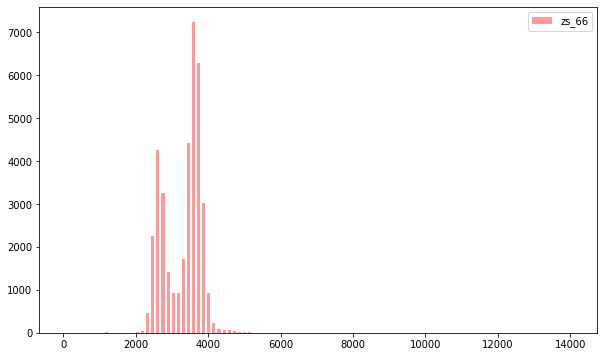

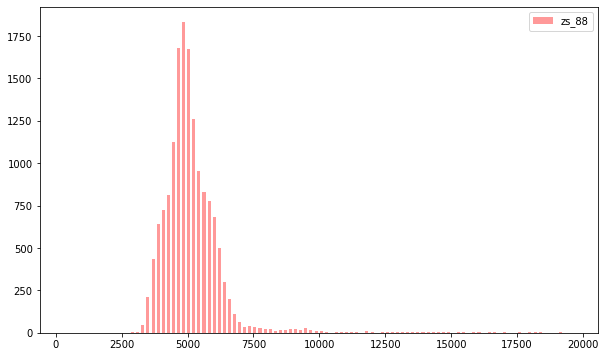

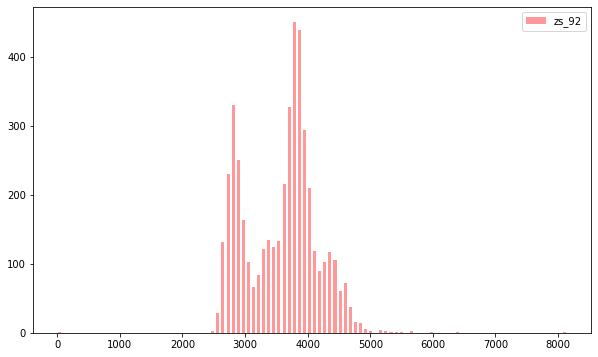

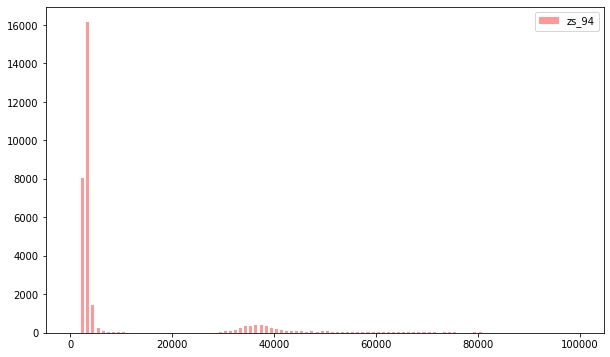

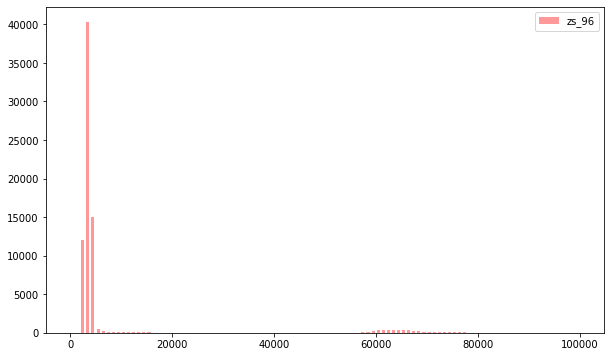

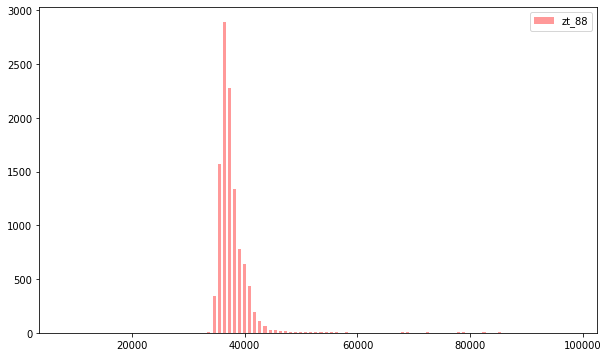

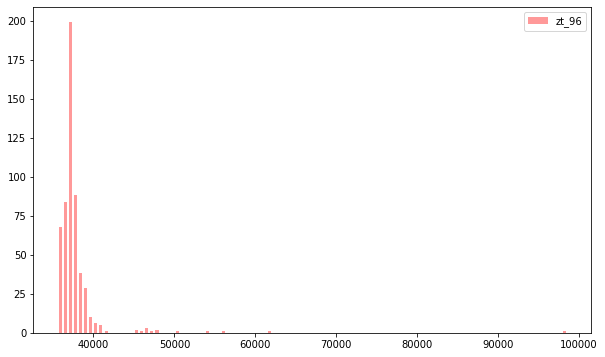

In [188]:
# for zs, set the x range to first 20ms
# for zt, set the x range to first 100ms
# for 6282, 6237 (HK servers), 200ms
import matplotlib.pyplot as plt
for i in np.sort(checkLog1['broker'].unique()):
    fig = plt.figure(figsize=(10, 6))
    ax1 = fig.add_subplot(111)
    ax1.hist(checkLog1[checkLog['broker'] == i]['time_diff'].values, bins=100, rwidth=0.6, alpha=0.4, color='red', label=i)
    ax1.legend()
    plt.show()